\begin{aligned}
\text{\huge{Surveillance des aubes par apprentissage automatique}}
\end{aligned}

# $\color{blue}{\text{1. Introduction générale}}$

La mesure de la vibration en tête d’aube connue sous le nom de mesure tip-timing est particulièrement répandue dans la surverillance des turboréacteurs. Elle mesure la déflexion en tête d’aube par des capteurs optiques, capacitifs, magnétiques ou électromagnétiques fixés sur le carter du système. Lorsque l’aube ne vibre pas, le temps de temps de passage de l’aube face au capteur sans contact est uniquement fonction de la vitesse de rotation, du rayon de rotation et de la position angulaire de l’aube. Lorsque l’aube vibre, elle passera plus tôt ou plus tard en face du capteur par rapport au temps de passage sans vibration. Et cette avance ou retard de passage de l’aube dépendra de la déflexion instantanée de l’aube, qui est une déviation de la position de l’aube sans vibration. L’exploitation du temps de passage permet ainsi d’estimer la vibration (ou la déflexion) de toutes les aubes.

A partir de cette déflexion, il est possible de déterminer les caractéristiques mécaniques de l’aube (amplitude de la vibration, fréquence de résonance et facteur d’amortissement). En raison de ces avantages, la mesure tip-timing devient de plus en plus répandue pour la surveillance et la caractérisation des aubes tournantes.
Il existe aujourd’hui à Safran Aircraft Engines le progiciel Agilis déployant une méthode d’estimation des déflexions des aubes. Cette méthode est connue sous le nom de « méthode center-time ». Cette méthode traditionnelle repose sur l’unique exploitation des temps de passage en tête des aubes. Elle fait l’hypothèse que la fréquence de rotation du moteur est constante dans le tour et ignore l’angle balayé par les aubes entre les temps de passage sans vibration et avec vibration. Or, l’hypothèse de constance de la fréquence de rotation n’est satisfaite que dans de rares applications ou sur de simples bancs d’essais. En effet, sur les moteurs d’aéronefs (hélicoptères ou avions), le régime de fonctionnement lors des phases d’essais est suffisamment élevé et peut être variable dans une rotation en raison de la forte accélération.
La méthode du center-time induit une énorme erreur dans l'estimation des déflexions. Cette erreur est corrigée par « zeroing » avec une fonction de correction appelée « fonction de zéro ». Cette dernière est une régression linéaire fonction du régime.  Cette correction est connue pour être sous optimale et est faite de manière subjective. D’un utilisateur à l’autre, nous obtenons des résultats différents ; ceci est une des sources d’incertitude non maitrisée dans la mesure tip-timing et la rendant ainsi non certifiant en essai.    
L’objectif de ce travail est d’automatiser l’étape de zeroing et de réduire l’erreur d’estimation des déflexions par rapport à la méthode traditionnelle. Il s'agit de supprimer, à partir d'une déflexion calculée, la ligne de base ou la tendance.   
Dans ce sens nous avons exploré plusieurs types d’approche : les approches basées modèles et les approches basées données (Machine Learning/Deep Learning). 

Cette notebook est structurée de la manière suivante. La section 2 présente le contexte la problématique du projet. La section 3 présente la formulation mathématique du problème. La section 4


# $\color{blue}{\text{ 2. Problématique et contexte du projet}}$

## 2.1 Contexte du projet

L'exploitation de temps de passage des aubes dans une mesure tip-timing permet de calculer la deflexion (deplacement) des aubes sur une turbomachine. Le clacul de cette déflexion présente une erreur (pour valoir plus que 1000 fois la déflexion réelle). Cela se traduit par la présence d'une ligne de base (baseline) ou une tendance dans la courbe de déflexion. CHez Safran AE, la baseline est estimée par une régression linéaire fonction de la fréquence de rotation du moteur. Cette correction est connue pour être sous-optimale et subjective. Ce qui rend aujourd'hui la mésure tip-timing moins pertinent que les jauges de déformations par exemple pour certifier des aubes. 

Une étape importante pour pourvoir utiliser le tip-timing pour certifier est de réduire au mieux toutes les erreurs dans la chaîne de traitement, notamment la prémière étape qui est l'estimation de la déflexion. Il s'agit dans ce projet de reduire l'erreur d'estimation de la déflexion (ou de la correction de la ligne de base) d'une part et d'autre part d'automatiser l'étape de correction de la déflexion initialement calculée.   

## 2.2 Zeroing de la déflexion par auto-zero

Le zeroing a pour principal but de corriger l'erreur induite par le calcul de la déflexion des aubes dans le center-time. Ceci en raison des hypothèses faite par le center-time. 
Dans les pratiques à SAE, il est supposé que l'erreur dépend principalement de la variation du régime (de la fréquence de rotation du rotor). A partir de cette hypothèse, la fonction de zéro, notée $Z_{i,j,k}$ est estimée en déhors des zones de résonances des aubes par une régression polynomiale telle que 

\begin{equation}
Z_{i,j,k} = \sum_{p=0}^{P} a_p (Fr_j)^p  
\end{equation}
$P$ est l'ordre du polynôme et $a_p$ les coefficients de la régression. A SAE, un polynôme d'ordre 1 est utilisé de façon systématique. 
Cette fonction zéro est extraite de la déflexion initiale calculée par center-time et permet d'obtenir la déflexion dynamique définie par 

\begin{equation}
D_{i,j,k}^{Dyn} = D_{i,j,k}^{CT}-Z_{i,j,k}
\end{equation}

La détermination des zones de zeros est faite généralement de manière automatique par une fonction d'auto-zero. Ces zones correspondent aux points de la différence de déflexion (différence de déflexion d'un capteur à l'autre pour une aube donnée) en dessous d'un seuil. 

Aujourd'hui le calcul de la fonction de zero n'est pas fondée sur un critère objectif. En effet, il n'existe aucun critère objectif permettant 
- de choisir l'ordre du polynôme de la régression
- de choisir la zone de zéro

Par ailleurs, la fonction zéro ne prend pas en compte toutes les erreurs commises par le center-time et la mesure elle-même.

D'où la necessité de trouver une méthode de correction de la déflexion (d'estimation de la ligne de base) ne faisant pas d'hypothèse sur la forme de la ligne de base. 
Dans la section suivante, nous presentons une formulation mathématique du problème général d'estimation de la ligne de base dans un signal. 

# $\color{blue}{\text{ 3. Formulation mathématique du problème de correction des déflexions des aubes}}$

Nous disposons d’un signal mesuré (ou simulé) $x \in R^N$ constitué d’un signal cible $y \in R^N$, d’une ligne de base (baseline) $b \in R^N$  et d’un bruit $n \in R^N$ tel que :
\begin{equation}
x=f(y,b,n)
\end{equation}
$f$ est la fonction reliant les différentes composantes au signal mesuré $x$. Le signal mesuré dont il s’agit est un signal de déflexion des aubes. L’objectif est d’estimer le signal $y_n$ non corrompu par la ligne de base mais bruité à partir du signal mesuré corrompu $x$. Nous supposerons dans la suite que la fonction est linéaire des composantes du signal mesuré tel que 
\begin{equation}
x=y_n+b
\end{equation}
Il s’agit de trouver la fonction $h_{\theta}$ paramétrée par $\theta \in R^N$ qui minimise l’erreur quadratique moyenne. De manière explicite :
\begin{equation}
\hat{\theta} = \underset{\theta}{argmin} \|y_n-h_{\theta}(x;\theta)\|_2^2
\end{equation}
Ainsi le signal non corrompu estimé est noté  $\hat{y}_n = h_{\hat{\theta}}(x;\hat{\theta})$. 


## $\color{blue}{\text{ 3.1 Approches de résolution du problème}}$

Nous avons exploré trois approches dans ce projet. Ce sont les suivantes : 
1. Approche traditionnelle : Régression polynomiale dans zones de non resonances avec la fonction auto-zero
2. Approche basée modèle : Penalized Least Square - Moindres carrées pénalisées
3. Approche basée donnée (avec du Deep Learning) : Architecture U-Net

## $\color{blue}{\text{ 3.2 Métriques d'évaluation des méthodes explorées}}$

Afin d'évaluer la performances des différentes méthodes dans cette notebook, nous utiliseons trois métriques. L'erreur quadratique moyenne normalisée (NMSE - Normalized Mean Squared Error), l'erreur absolue moyenne (MAE - Mean Absolute Error) et l'index de mesure de la similarité structurelle (SSIM -Structural Similarity Index Measure) . Pour un signal $x$ et une estimation $\hat{x}$ de loçngeur $N$, ces métriques sont définies comme :

\begin{equation}
NMSE(x;\hat{x}) = 100* \frac{\sum_{i=1}^{N} (x_i-\hat{x}_i)^2}{\sum_{i=1}^{N} x_i^2}
\end{equation}
et

\begin{equation}
MAE(x;\hat{x}) = \frac{1}{N}\sum_{i=1}^{N} | x_i-\hat{x}_i|
\end{equation}

Pour les données réelles, le signal original $x$ n'est pas accéssible. Dans ce contexte, nous proposons une métrique provenant du traitement d'image : le SSIM (Structural Similarity Index Measure). Il est exprimé comme :

\begin{equation}
ssim(x;\hat{x}) = l(x;\hat{x}) \times c(x;\hat{x}) \times s(x;\hat{x})
\end{equation}

Dépendant de la moyenne 
\begin{equation}
l(x;\hat{x}) = \frac{2 \mu_x \mu_{\hat{x}}}{\mu_x^2+\mu_{\hat{x}}^2}
\end{equation}

De l’écart-type 
\begin{equation}
c(x;\hat{x})=\frac{2 \sigma_x \sigma_{\hat{x}}}{\sigma_x^2+\sigma_{\hat{x}}^2}
\end{equation}

Et de la covariance
\begin{equation}
s(x;\hat{x})=\frac{cov(x;\hat{x})}{\sigma_x \sigma_{\hat{x}}}
\end{equation}


In [13]:
# Définition de la métrique NMSE
import numpy as np
def nmse(y_pred,y_true):
    return (100*np.mean((y_pred-y_true)**2)/np.mean(y_true**2))

In [14]:
# Definition de la métrique ssim
from statsmodels.tsa.stattools import acf

def ssim(X, Y, K1=0.01, K2=0.03):
    """
    Calcule la mesure de similarité structurelle pour les séries temporelles (ssim)
    entre deux séries X et Y.

    Article de référence : Unveiling Structural Similarity in Time Series through Image Similarity Assessment Insights".

    Args:
        X (np.array): La première série temporelle (1D).
        Y (np.array): La deuxième série temporelle (1D).
        K1 (float): Constante de stabilisation pour la tendance.
        K2 (float): Constante de stabilisation pour la variabilité/structure.

    Returns:
        float: La valeur de similarité ssim, comprise entre 0 et 1.
    """
    if X.ndim != 1 or Y.ndim != 1:
        raise ValueError("Les séries temporelles doivent être des tableaux 1D.")
    if len(X) != len(Y):
        raise ValueError("Les séries temporelles doivent avoir la même longueur.")

    m = len(X)
    if m == 0:
        return 1.0 # Deux séries vides sont parfaitement similaires.

    # --- 1. Similarité de Tendance (Trend Similarity) ---
    # Calcul des pentes de régression linéaire
    time_index = np.arange(m)
    mu_X = np.polyfit(time_index, X, 1)[0]
    mu_Y = np.polyfit(time_index, Y, 1)[0]

    # --- 2. Mesure de Variabilité (Variability Measurement) ---
    # Calcul des variances
    sigma_X_sq = np.var(X)
    sigma_Y_sq = np.var(Y)

    # --- 3. Analyse de Corrélation Structurelle (Structural Correlation) ---
    # Calcul des fonctions d'autocorrélation (ACF)
    # nlags doit être identique pour les deux séries pour pouvoir les comparer
    nlags = m - 1
    acf_X = acf(X, nlags=nlags, fft=True)
    acf_Y = acf(Y, nlags=nlags, fft=True)
    
    # Calcul de la corrélation cosinus entre les ACFs 
    # Gère le cas où l'un des ACF est nul pour éviter la division par zéro
    norm_acf_X = np.linalg.norm(acf_X)
    norm_acf_Y = np.linalg.norm(acf_Y)
    if norm_acf_X == 0 or norm_acf_Y == 0:
        sigma_XY = 1.0 if norm_acf_X == norm_acf_Y else 0.0
    else:
        sigma_XY = np.dot(acf_X, acf_Y) / (norm_acf_X * norm_acf_Y)

    # --- 4. Combinaison et calcul final ---
    # Calcul des constantes de stabilisation C1 et C2
    # L est la plage dynamique des valeurs des signaux
    L = np.max(np.concatenate([X, Y])) - np.min(np.concatenate([X, Y]))
    C1 = (K1 * L)**2
    C2 = (K2 * L)**2
    
    # 
    numerator = (2 * mu_X * mu_Y + C1) * (2 * sigma_XY + C2)
    denominator = (mu_X**2 + mu_Y**2 + C1) * (sigma_X_sq + sigma_Y_sq + C2)

    if denominator == 0:
      return 1.0 if numerator == 0 else 0.0

    return numerator / denominator

# $\color{blue}{\text{ 4. Exploration de la base de donnée de déflexions}}$

Nous disponsons dans ce projet d'une base de donnée d'essai moteur (données réelles) et d'une base de données synthétique. Cette dernière provient d'un simulateur de données tip-timing basé sur un modèle à un dégré de liberté de la roue aubagée. 

Les données réelles sont des données corrompues pour lesquelles la ligne de base est inconnue. C'est la raison pour laquelle, nous allons exploité dans un premier temps des données simulées similaires au mieux aux données réelles. 

In [2]:
# Chargement des données réelles dans le répertoire dedié
import os
import glob

import pandas as pd
import matplotlib.pyplot as plt

pathname = './donnees_reelles'
files = glob.glob(os.path.join(pathname, '*filt*.csv'))  # list all *.xlsx files
files = [os.path.basename(f) for f in files]  # file names
fname = [os.path.join(pathname, f) for f in files]  # full path to file


In [4]:
# Affichage dataframe
j = 5           # jeme fichier de la donnée réelle
print(fname[j])
df = pd.read_csv(fname[j],sep=',')
for i in range(4):
    df = df.drop([df.columns[0]],axis=1)
df = df-df.mean()
df.head()


./donnees_reelles\09_14_2015_19_30_21.070_t-BF_BA_Longis_Top_Tour_condbwf_filtrage_08.csv


,P# 1:Bld# 1 (zf mm ),P# 1:Bld# 2 (zf mm ),P# 1:Bld# 3 (zf mm ),P# 1:Bld# 4 (zf mm ),P# 1:Bld# 5 (zf mm ),P# 1:Bld# 6 (zf mm ),P# 1:Bld# 7 (zf mm ),P# 1:Bld# 8 (zf mm ),P# 1:Bld# 9 (zf mm ),P# 1:Bld# 10 (zf mm ),...,P# 6:Bld# 9 (zf mm ),P# 6:Bld# 10 (zf mm ),P# 6:Bld# 11 (zf mm ),P# 6:Bld# 12 (zf mm ),P# 6:Bld# 13 (zf mm ),P# 6:Bld# 14 (zf mm ),P# 6:Bld# 15 (zf mm ),P# 6:Bld# 16 (zf mm ),P# 6:Bld# 17 (zf mm ),P# 6:Bld# 18 (zf mm )
0,1.246181,1.430999,1.091197,0.854989,1.369462,1.342201,0.662731,1.305617,1.222042,1.375872,...,0.219198,0.314988,0.174541,-0.365912,0.257745,0.530604,0.152737,-0.026951,-0.475697,-0.464805
1,1.248181,1.431999,1.092197,0.853989,1.372462,1.342201,0.661731,1.303617,1.221042,1.371872,...,0.218198,0.315988,0.173541,-0.365912,0.257745,0.527604,0.152737,-0.028951,-0.477697,-0.467805
2,1.244181,1.430999,1.090197,0.844989,1.370462,1.347201,0.659731,1.298617,1.219042,1.369872,...,0.217198,0.317988,0.171541,-0.363912,0.255745,0.526604,0.153737,-0.029951,-0.478697,-0.467805
3,1.241181,1.431999,1.085197,0.848989,1.373462,1.352201,0.658731,1.297617,1.213042,1.369872,...,0.217198,0.321988,0.175541,-0.363912,0.258745,0.532604,0.158737,-0.026951,-0.478697,-0.465805
4,1.238181,1.416999,1.082197,0.846989,1.379462,1.362201,0.661731,1.296617,1.211042,1.383872,...,0.221198,0.325988,0.173541,-0.364912,0.261745,0.536604,0.164737,-0.021951,-0.472697,-0.458805


La figure ci-dessous est exemple de déflexion réelle d'aube de moteur. Nous observons la présence d'une tendance dans la donnée qui n'est pas souhaitée et qui conduit à une mauvaise estimation des résonances (pics dans la courbe de déflexion). L'erreur sera d'autant grand que le pics à la résonance est faible. 

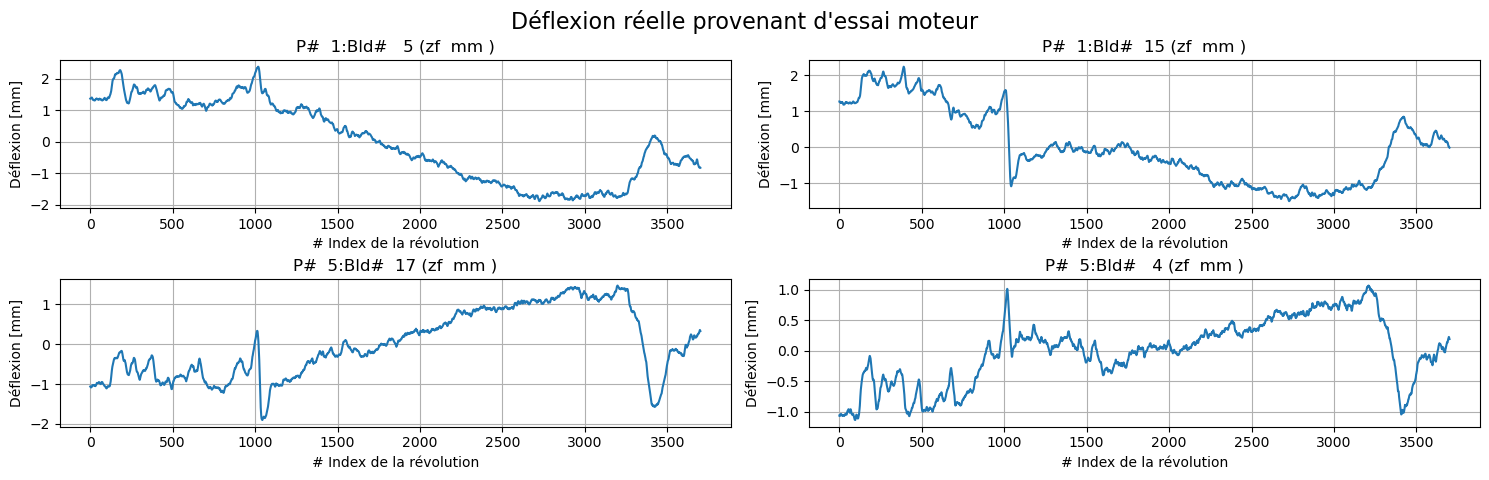

In [6]:
i = np.random.randint(0,np.shape(df)[1],4)
it = 0
fig = plt.figure(figsize=(15,5))
for p in i:
    it+=1
    plt.subplot(2,2,it)
    plt.plot(df.iloc[:,p])
    plt.title(df.columns[p])
    plt.grid()
    plt.xlabel('# Index de la révolution')
    plt.ylabel('Déflexion [mm]')
plt.tight_layout()
st = plt.suptitle("Déflexion réelle provenant d'essai moteur", fontsize=16)
# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.85)

plt.show()

## $\color{blue}{\text{ 4.1 Génération des données simulées}}$

Nous ne disposons pas, dans la vraie vie, de données de déflexions non corrompues par une baseline. Par conséquent, il n'existe donc pas de données pouvant répresenter la vérité terrain. C'est la raison pour laquelle, nous avons choisi de générer nos données à partir d'un simulateur de données tip-timing. Ce simulateur est basé sur un modèle mécanique à un dégré de liberté (modèle masse-ressort-amortissement) excité par des ordres moteur définis. Il est suffisament répresentatif des types de réponses que nous rencontrons lors des essais moteur.
La description detaillée du simulateur ne fait l'objet de ce document.

Les données du simulateur seront utilisées pour entrainer le modèle de deep learning. Les données réelles seront utiliseés pour le test et la comparaison avec les méthodes basées modèles. 


In [15]:
# Import des librairies

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tqdm
from blade_assembly_config import blade_assembly_config
from simulation.Theoretical_AOA import Theoretical_AOA
from preprocessing.center_time import center_time
from preprocessing.center_time import *

### $\color{blue}{\text{ Fonction d'ajout du bruit}}$

In [16]:
def add_noise(Toa_struct,ToaR_struct,Ra,Reg_struct,sigma):
    # Initalisation
    Na =  Toa_struct.shape[0] 
    Nct =  Toa_struct.shape[2]
    nbr_tour =  Toa_struct.shape[1]
    Toa_struct_noise = np.zeros((Na, nbr_tour, Nct))
    Def_struct_noise = np.zeros((Na, nbr_tour, Nct))
    # Generation de burit aleatoire d'ecart-tyoe sigma


    # Ajout de bruit
    for i in range(Na):
        for k in range(Nct):
            noise = np.random.normal(0, 1, Toa_struct.shape[1])
            noise=noise*sigma
            Toa_struct_noise[i, :, k] = Toa_struct[i, :, k] + noise
            Def_struct_noise[i, :, k]= (Toa_struct_noise[i,:,k]-ToaR_struct[i, :, k])*(Ra * 2 * np.pi * Reg_struct[i, :, k] / 60)

    return Toa_struct_noise,Def_struct_noise

### $\color{blue}{\text{ Fonction de génération des déflexions}}$

In [17]:
def find_Toa_Def_multi_peaks(theta, theta_theoretical, time, regime, Ra, Position_CTT, EO, f_resonance, xi,Amax):
    Na = theta_theoretical.shape[0]
    nbr_tour = theta_theoretical.shape[1]
    Nct = theta_theoretical.shape[2]

    time = time.flatten()
    regime = regime.flatten()

    w0 = 2 * np.pi * f_resonance

    noise_std = np.zeros((Na, Nct))
    Def_struct = np.zeros((Na, nbr_tour, Nct))

    ToaR_struct = np.zeros((Na, nbr_tour, Nct))
    Reg_struct = np.zeros((Na, nbr_tour, Nct))
    amp_struct = np.zeros((Na, nbr_tour, Nct))
    phi_struct = np.zeros((Na, nbr_tour, Nct))
    Toa_struct = np.zeros((Na, nbr_tour, Nct))

    for i in range(Na):
        for k in range(Nct):
            AoA = theta_theoretical[i, :, k]
            ToaR_struct[i, :, k] = np.interp(AoA, theta, time)
            Reg_struct[i, :, k] = np.interp(AoA, theta, regime)

            for z in range(len(EO)):
                w = 2 * np.pi * Reg_struct[i, :, k] * EO[z] / 60
                amp_struct[i, :, k] = 1 / np.sqrt((2 * xi[z] * w0[z] * w) ** 2 + (w0[z] ** 2 - w ** 2) ** 2)
                amp_struct[i, :, k]  = amp_struct[i, :, k]*Amax[z]/np.max(amp_struct[i, :, k])
                phi_struct[i, :, k] = EO[z] * 2 * np.pi * (i - 1) / Na + np.arctan2(-2 * xi[z] * w0[z] * w, (w0[z] ** 2 - w ** 2))

                Def_struct[i, :, k] += amp_struct[i, :, k] * np.sin(EO[z] * np.deg2rad(Position_CTT[k]) + phi_struct[i, :, k])
            Toa_struct[i, :, k] = ToaR_struct[i, :, k] + (Def_struct[i, :, k] / (Ra * 2 * np.pi * Reg_struct[i, :, k] / 60))

    return ToaR_struct, Toa_struct, Def_struct, Reg_struct, amp_struct, phi_struct, noise_std

### $\color{blue}{\text{ Fonction de génération de la base de données complète}}$

In [18]:
def generate_ct_dataset(
    ordre=1,
    band=0.05,
    correc="yes",
    zeroing="no",
    sigma_min=0,
    sigma_max=30,
    max_samples=1000,
    Na=10,
    Ra=200*1e3,
    fs=2.5e4,
    reg_init=4000,
    reg_end=8000,
    reg_acc=200,
    SIGNAL_LENGTH = 1600,
):
    """
    Génère un dataset multi-pics de déflexions Center-Time et vraies déflexions
    avec Amax, xi et snr tirés aléatoirement.
    Retourne X (CT), Y (réel), Baseline.
    """
    # Positions des aubes et capteurs
    Position_Blade, Position_CTT, Nct = blade_assembly_config(Na)

    X_ct_list, Y_real_list, Baseline_list,DCt_list = [], [], [], []
    print(f"Génération de {max_samples} signaux Center-Time multi-pics...")
    pbar = tqdm.tqdm(total=max_samples, desc="Signaux générés")

    while len(X_ct_list) < max_samples:
        # --- Tirage aléatoire des paramètres physiques
        n_modes=np.random.randint(3,7)
        Amax = np.random.uniform(10, 30,n_modes)
        xi = np.random.uniform(8e-4, 5e-3, n_modes)      # amortissement aléatoire
        sigma = np.random.uniform(sigma_min, sigma_max)        # bruit aléatoire
        EO_list=np.random.randint(22,76,n_modes)


        # --- Temps et régime moteur
        Duration = (reg_end - reg_init) / reg_acc
        time = np.arange(0, Duration, 1/fs)
        regime = reg_init + time * reg_acc
        f_resonance = np.array([np.random.randint(min(regime), max(regime)) * eo / 60 for eo in EO_list])

        # --- Calcul des positions théoriques (AOA)
        theta = 2 * np.pi * np.cumsum(regime / 60) / fs
        nbr_tour = int(np.fix((np.max(theta) - 2 * np.pi * (np.max(Position_CTT) - np.min(Position_Blade)) / 360) / (2 * np.pi)))
        sens = "anhoraire"
        theta_theoretical = Theoretical_AOA(Position_Blade, Position_CTT, nbr_tour, sens)

        # --- Simulation multi-pics
        ToaR_struct, Toa_struct, Def_struct, Reg_struct, _, _, _ = find_Toa_Def_multi_peaks(
            theta, theta_theoretical, time, regime, Ra, Position_CTT,
            EO_list, f_resonance, xi,Amax)

        
        
        # --- Ajoiut de bruit sur les Toa et les defeleixoxn equivalents
        Toa_struct_noise,Def_struct_noise = add_noise(Toa_struct,ToaR_struct,Ra,Reg_struct,sigma)

        # --- Center-Time
        reg_min = [reg_init, (1-band)*reg_end]
        reg_max = [reg_init*(1 + band), reg_end]
        select_revolution = np.arange(5, nbr_tour-5, 1)
        DCt, _, _, _, _ = center_time(Toa_struct_noise, Ra, correc, select_revolution)

         # --- Baseline (différence entre vrai signal et CT)
        baseline = np.zeros((Na,len(select_revolution),8))
        DCt_list.append(DCt)
        # --- Stockage (pour chaque aube/capteur)
        for i in range(Na):
            for k in range(Nct):
                if len(X_ct_list) >= max_samples:
                    break
                DCt[i,:,k] = DCt[i,:,k] - np.mean(DCt[i,:,k])
                baseline[i,:,k] = -(Def_struct_noise[i, select_revolution, k] - DCt[i,:,k])
                X_ct_list.append(DCt[i,:SIGNAL_LENGTH,k])
                Y_real_list.append(Def_struct_noise[i,select_revolution[:SIGNAL_LENGTH],k])
                Baseline_list.append(baseline[i,:SIGNAL_LENGTH,k])

        pbar.update(Na*Nct if len(X_ct_list) < max_samples else max_samples - len(X_ct_list))
    pbar.close()

    # Conversion en tableaux + ajout de l'axe canal
    X_ct = np.array(X_ct_list)[:max_samples][..., np.newaxis]
    Y_real = np.array(Y_real_list)[:max_samples][..., np.newaxis]
    Baseline = np.array(Baseline_list)[:max_samples][..., np.newaxis]
    DCt_raw = np.array(DCt_list)
    return X_ct, Y_real, Baseline,DCt_raw,Reg_struct[:,select_revolution,:]/60,Def_struct


### $\color{blue}{\text{ Génération du dataset synthétique}}$

In [23]:
# --- Génération du dataset ---
X_ct, Y_real, Baseline,DCt_raw, Fr,Def_struct = generate_ct_dataset(
max_samples=160,      # nombre de signaux. Une configuration de machine fait 8*Na exemples
sigma_min=0*1e-9, sigma_max=20*1e-9,  # plage de bruit
Na=20,                  # nombre d'aubes   # Engine Orders multiples
)

Génération de 160 signaux Center-Time multi-pics...


Signaux générés:   0%|          | 0/160 [00:00<?, ?it/s]


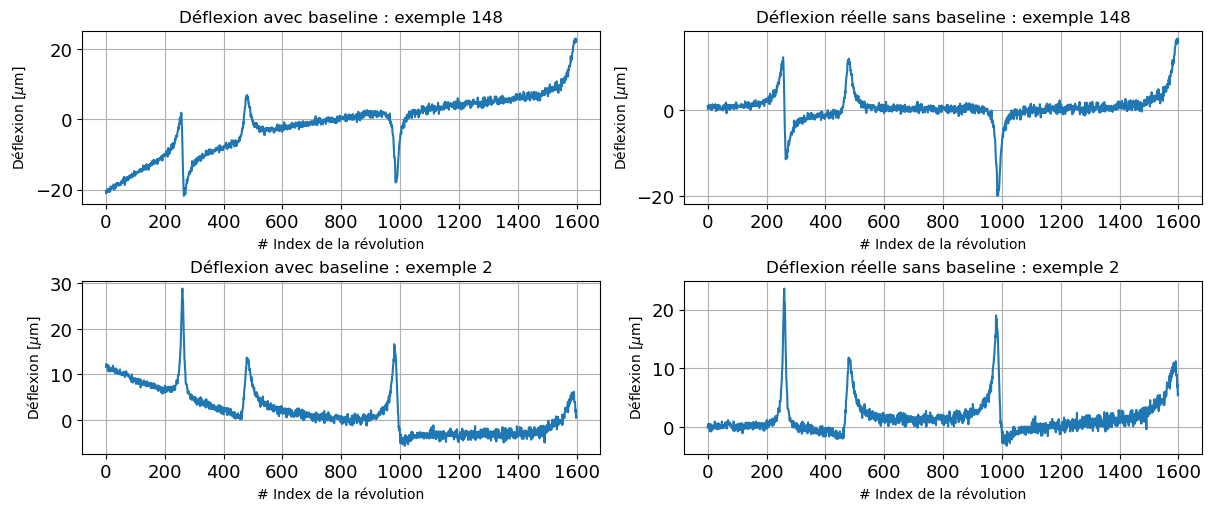

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 5),constrained_layout=True)
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)

i= np.random.randint(0,160,2)

plt.subplot(2,2,1)
plt.plot(X_ct[i[0],:,0])
plt.title('Déflexion avec baseline : exemple {}'.format(i[0]))
plt.grid('on')
plt.ylabel(r'Déflexion [$\mu$m]')
plt.xlabel('# Index de la révolution')


plt.subplot(2,2,2)
plt.plot(Y_real[i[0],:,0],label= '')
plt.title('Déflexion réelle sans baseline : exemple {}'.format(i[0]))
plt.grid('on')
plt.ylabel(r'Déflexion [$\mu$m]')
plt.xlabel('# Index de la révolution')

plt.subplot(2,2,3)
plt.plot(X_ct[i[1],:,0])
plt.title('Déflexion avec baseline : exemple {}'.format(i[1]))
plt.grid('on')
plt.ylabel(r'Déflexion [$\mu$m]')
plt.xlabel('# Index de la révolution')

plt.subplot(2,2,4)
plt.plot(Y_real[i[1],:,0],label= '')
plt.title('Déflexion réelle sans baseline : exemple {}'.format(i[1]))
plt.grid('on')
plt.ylabel(r'Déflexion [$\mu$m]')
plt.xlabel('# Index de la révolution')

plt.show()

La figure ci-dessus affiche à gauche la déflexion calculée sans supression de la baseline. A droité, nous affichons la déflexion réelle sans baseline correspondante. 

# $\color{blue}{\text{ 5. Analyse de la performance de l'auto-zero (Approche actuelle à SAE)}}$

## $\color{blue}{\text{ 5.1 Estimation de quelques déflexions par l'auto-zero}}$

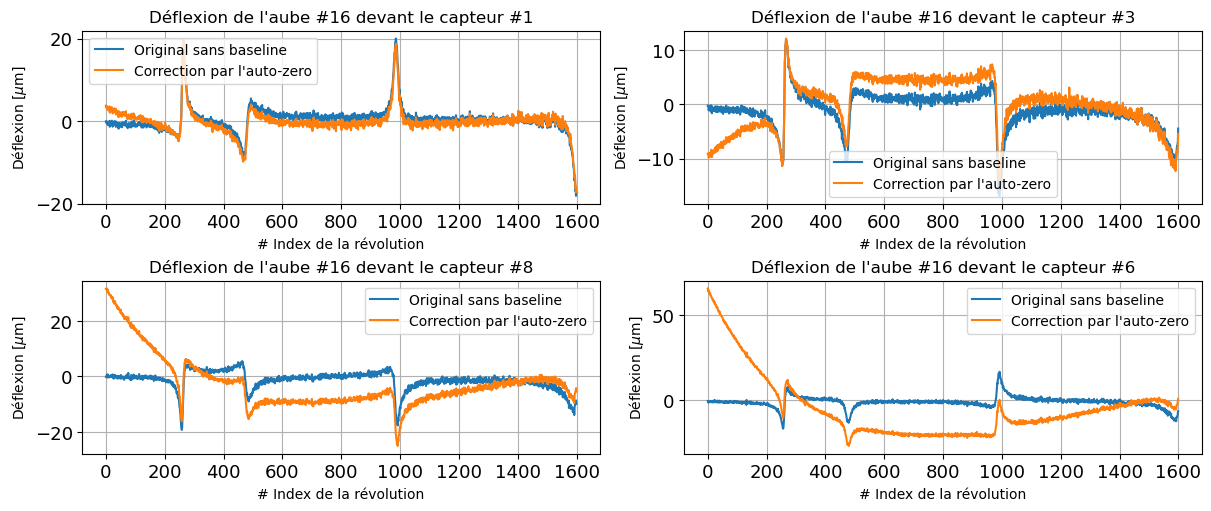

In [25]:
ordre = 1   # ordre du polynôme à choirir entre 0 et 3 par exemple
S = 0.2   # Seuil sur les enveloppes de déflexion pour détection de zone de zero. Choisir entre 0.1 et 0.5
iter = 5  # Nombre d'itération dans la fonction zero
from auto_zero import *
Dzero = autozero(DCt_raw[0,:,:,:], Fr[0,:,0], ordre, S, iter)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 5),constrained_layout=True)
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
s = 0
for i in [15]:#[0,2,10,50]:
    for k in [0,2,7,5]:
        s = s+1
        plt.subplot(2,2,s)
        plt.plot(Y_real[8*i + k,:,0],label= 'Original sans baseline')
        plt.plot(Dzero[i,:1600,k],label= "Correction par l'auto-zero")
        plt.xlabel('# Index de la révolution')
        plt.ylabel(r'Déflexion [$\mu$m]')
        plt.title("Déflexion de l'aube #{} devant le capteur #{}".format(i+1,k+1), fontsize=12)
        
        plt.grid('on')
        plt.legend()
plt.show()

La figure ci-dessus montre que la corection faite par l'auto-zero avec les paramètres standard utilisés à SAE ne fournissent pas une correction optimale. L'écart entre la déflexion originale et celle corrigée est important pour les couples aubes/capteurs : (16/8) et (16/6).

## $\color{blue}{\text{ 5.2 Impact des paramètres de l'auto-zero sur la performance de correction}}$

Ici, nous faisons varier le seuil ($S$) de l'auto-zero (influencant le choix de la zone de calcul des coefficients de la régression polynomiale) et l'ordre la régression ($P$) et estimons la moyenne des métriques (NMSE, MAE et SSIM) et l'écart-type correspondant. 

In [27]:
from auto_zero import *
P = [1,2,3]
seuil = [0.1,0.2,0.3] #,0.3,0.4]
Na = np.shape(DCt_raw[0,:,:,:])[0]
Nct = np.shape(DCt_raw[0,:,:,:])[1]
init = np.zeros((len(P)*len(seuil)*Na*Nct,))
df = pd.DataFrame({'Ordre du polynôme':init,
                   'Seuil auto-zero':init,
                   'aube':init,
                   'capteur':init,
                   'NMSE':init})

select_revolution = np.arange(5, np.shape(Fr)[1]-5)
error_mean = np.zeros((len(P),len(seuil)))
error_std = np.zeros((len(P),len(seuil)))

ssim_mean = np.zeros((len(P),len(seuil)))
ssim_std = np.zeros((len(P),len(seuil)))

mae_mean = np.zeros((len(P),len(seuil)))
mae_std = np.zeros((len(P),len(seuil)))
iter = 0
i = 0
for ordre in P:
    
    j = 0
    for S in seuil:
        
        Dzero = autozero(DCt_raw[0,:,:,:], Fr[0,:,0], ordre, S, 5)
        tmp1 = []
        tmp2 = []
        tmp3 = []
        for aub in range(np.shape(Dzero)[0]):
            for capt in range(np.shape(Dzero)[2]):

                tmp1.append(nmse(Dzero[aub,:1600,capt],Y_real[8*aub+capt,:,0]))
                tmp2.append(ssim(Dzero[aub,:1600,capt],Y_real[8*aub+capt,:,0]))
                tmp3.append(mean_absolute_error(Dzero[aub,:1600,capt],Y_real[8*aub+capt,:,0]))

        tmp1 = np.array(tmp1)
        tmp2 = np.array(tmp2)
        tmp3 = np.array(tmp3)

        error_mean[i,j] = np.mean(tmp1) 
        error_std[i,j] = np.std(tmp1)

        ssim_mean[i,j] = np.mean(tmp2) 
        ssim_std[i,j] = np.std(tmp2)

        mae_mean[i,j] = np.mean(tmp3) 
        mae_std[i,j] = np.std(tmp3)
        j= j+1

    i = i+1

c:\Users\s602073\Documents\Technical_Staffs\Formation DS_SU\Projet\Pour_le_rapport\auto_zero.py:99: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(Regzone.ravel(), Def[blade, zone, k].ravel(), ordre,rcond=1e-16) #, mu
c:\Users\s602073\Documents\Technical_Staffs\Formation DS_SU\Projet\Pour_le_rapport\auto_zero.py:99: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(Regzone.ravel(), Def[blade, zone, k].ravel(), ordre,rcond=1e-16) #, mu
c:\Users\s602073\Documents\Technical_Staffs\Formation DS_SU\Projet\Pour_le_rapport\auto_zero.py:99: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(Regzone.ravel(), Def[blade, zone, k].ravel(), ordre,rcond=1e-16) #, mu
c:\Users\s602073\Documents\Technical_Staffs\Formation DS_SU\Projet\Pour_le_rapport\auto_zero.py:99: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(Regzone.ravel(), Def[blade, zone, k].ravel(), ordre,rcond=1e-16) #, mu
c:\Users\s602073\Documents\Technical_Staffs\Formation DS_SU\

Text(0.5, 1.0, 'SSIM sur les 160 déflexions')

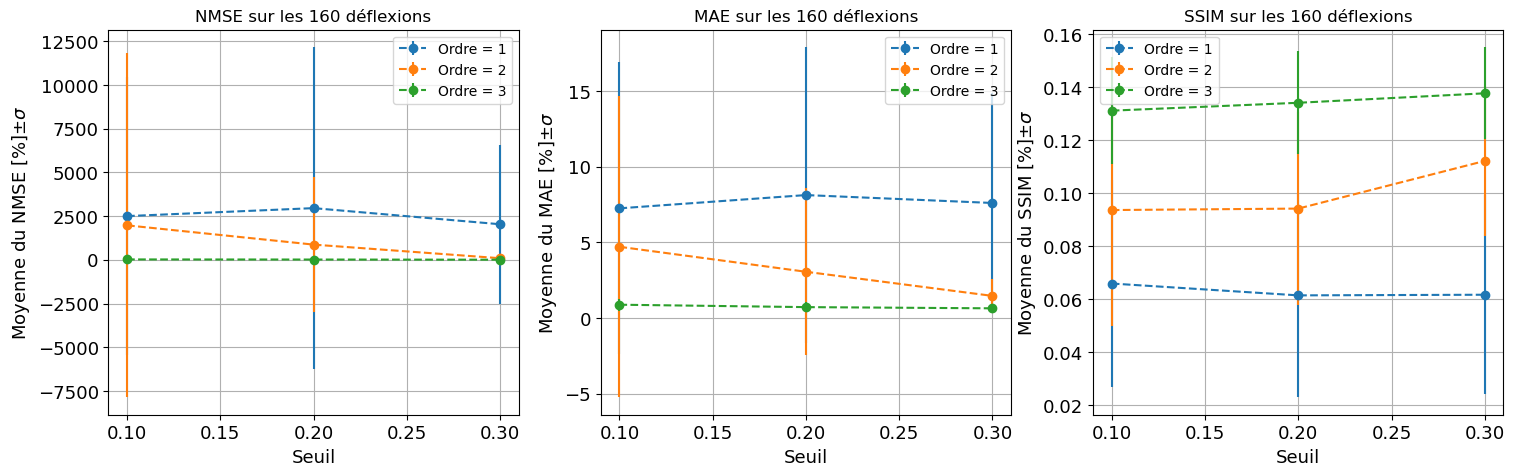

In [28]:
plt.figure(figsize=(18,5))

plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)

plt.subplot(1,3,1)
plt.errorbar(x=seuil, y=error_mean[0,:],yerr=error_std[0,:],fmt='--o',label='Ordre = {}'.format(P[0]))
plt.errorbar(x=seuil, y=error_mean[1,:],yerr=error_std[1,:],fmt='--o',label='Ordre = {}'.format(P[1]))
plt.errorbar(x=seuil, y=error_mean[2,:],yerr=error_std[2,:],fmt='--o',label='Ordre = {}'.format(P[2]))
plt.xlabel('Seuil',fontsize=13)
plt.ylabel(r'Moyenne du NMSE [%]$\pm \sigma$',fontsize=13)
# plt.ylim(0,50)
plt.grid()
plt.legend()
plt.title('NMSE sur les 160 déflexions')


plt.subplot(1,3,2)
plt.errorbar(x=seuil, y=mae_mean[0,:],yerr=mae_std[0,:],fmt='--o',label='Ordre = {}'.format(P[0]))
plt.errorbar(x=seuil, y=mae_mean[1,:],yerr=mae_std[1,:],fmt='--o',label='Ordre = {}'.format(P[1]))
plt.errorbar(x=seuil, y=mae_mean[2,:],yerr=mae_std[2,:],fmt='--o',label='Ordre = {}'.format(P[2]))
plt.xlabel('Seuil',fontsize=13)
plt.ylabel(r'Moyenne du MAE [%]$\pm \sigma$',fontsize=13)
# plt.ylim(0,50)
plt.grid()
plt.legend()
plt.title('MAE sur les 160 déflexions')

plt.subplot(1,3,3)
plt.errorbar(x=seuil, y=ssim_mean[0,:],yerr=ssim_std[0,:],fmt='--o',label='Ordre = {}'.format(P[0]))
plt.errorbar(x=seuil, y=ssim_mean[1,:],yerr=ssim_std[1,:],fmt='--o',label='Ordre = {}'.format(P[1]))
plt.errorbar(x=seuil, y=ssim_mean[2,:],yerr=ssim_std[2,:],fmt='--o',label='Ordre = {}'.format(P[2]))
plt.xlabel('Seuil',fontsize=13)
plt.ylabel(r'Moyenne du SSIM [%]$\pm \sigma$',fontsize=13)
# plt.ylim(0,50)
plt.grid()
plt.legend()
plt.title('SSIM sur les 160 déflexions')

### Commentaires

La figure ci-dessus affiche les métriques obtenues par l'auto-zero (méthode traditionnelle)'en fonction de l'ordre de la régression polynomiale et de la largeur de la zone de zéro. 
Nous rappellons qu'une bonne estimation conduit à des valeurs de NMSE et de MAE les plus faibles possibles (zero si l'estimation est parfaite). Pour ce qui concerne le SSIM, elle est maximale pour une bonne estimation et bornée par 1.
Nous observons qu'avec un polynôme d'ordre 3 et un seuil de 0.3 nous obtenons les métriques les plus optimales pour cette configuration de machine. 

Sur des données réelles, le choix des paramètres, dégré du polynôme et zone de zero, de la fonction zero n'est pas guidé par un critère objectif basé sur une métrique. A SAE par exemple, il est recommandé de choisir un polynôme d'ordre 1 et un seuil à 0.2. Comme on le voit sur la figure ci-dessus, ce couple de paramètre n'est pas celui qui fournit la plus petite erreur. 
D'ou la necessité de trouver une méthode automatique et plus fiable que la méthode traditionnelle dans cette étape de l'analyse tip-timing.   

$\color{magenta}{\text{Dans la prochaine section, nous explorons une nouvelle méthode basée modèle permettant d'estimer la baseline d'un signal quelconque. 
}}$

# $\color{blue}{\text{ 6. Approche basée modèle : Moindres carrées penalisées}}$

Dans l'approche basée modèle, nous proposons d'appliquer la méthode des moindres carrées penalisées. Cette une méthode très populaire dans la litterature scientifique ([Ref_article](https://www.sciencedirect.com/science/article/pii/S0924203125000402)) pour le problème d'estimation de la ligne de base. Elle estime la baseline $b$ en optimisant la fonction coût suivante :

\begin{equation}
J = \|y-b \|^2_{2,W}+\lambda \alpha \|D^{(2)}b \|^2_{2}
\end{equation}

$W$ et $\alpha$  sont calculés automatiquement dans le papier de référence. Pour le paramètre $\lambda$ il n'exitse pas de critère pour le choisir sauf si la vraie baeline est connue.

Nous explorons ci-dessous l'impact de la valeur de $\lambda$ sur les métriques NMSE,MAE et SSIM. 

In [26]:
#Algo NasPLS

# Matrice de lissage de l'estimation
from scipy import stats
from scipy.sparse import diags # manipuler des matrices creuses (rapide pour gros signaux)
from scipy.sparse.linalg import spsolve # résoudre des systèmes linéaires (calculs de baseline)
def mat_diff_snd_ordre(N):
    diagonals = [np.ones(N), -2*np.ones(N), np.ones(N)]
    return diags(diagonals, [0, 1, 2], shape=(N-2, N))


def naspls(y, lambdas, niter=15, tol=1e-4, y_baseline=None,epsilon=0.99):
    """y est le signal à corriger, mask est le masque des zones non sensibles, lambda est le paramètre de régularisation, niter le nombre d'itérations,
    tol la tolérance pour la convergence et y_baseline est optionnel c'est la baseline réelle utilisée en simulation pour évaluer la performance."""

    N = len(y)
    D = mat_diff_snd_ordre(N)

    best_rmse = np.inf
    best_z = None
    best_lambda = None
    base_estimated = []
    rmse_bas = []
    corr_coeff = []
    for lam in lambdas:
    
        w = np.ones(N) # poids pour chaque point du signal
        alpha = np.ones(N) # poids d’adaptation pour la régularisation (spécificité NasPLS)
        z = np.zeros(N) # baseline initiale (mise à zéro pour la première itération)
        i = 0
        for i in range(niter):
            W = diags(w, 0)
            A = W + lam * diags(alpha, 0) @ (D.T @ D)
            z_new = spsolve(A, W @ y)
            alpha = np.abs(y - z_new) / (np.max(np.abs(y - z))) # Mise à jour de alpha. Qd la différence en val abs de y-z_new est grande, la pénalité de régularisation est ajustée pour que la baseline ne suive pas de trop près les pics.
            
            
            d = y - z_new
        
            d_neg = d[d<0]
            # Éviter la division par zéro si d_neg est vide ou si l'écart-type est nul
            if len(d_neg) > 0 and np.std(d_neg) != 0:
                s = np.std(d_neg)
                m = np.mean(d_neg)
                # Variante de la fonction sigmoïde pour la mise à jour des poids
                w_new = 1 / (1 + np.exp(4*(d - (-1*m+2*s)) / s))
            else: # Si pas de points sous la ligne de base, garder les poids
                #print(True)
                w_new = np.ones(N)

            if np.linalg.norm(w_new - w) / (np.linalg.norm(w)) < tol:
                break
        
            w = w_new
            z = z_new

        base_estimated.append(z)
        if y_baseline!=None:
            rmse_bas.append(np.sqrt(np.mean((z - y_baseline)**2)))
        else:
            rmse_bas = 0
        corr_coeff.append(stats.spearmanr(np.gradient(y-z), np.gradient(y))[0])
    
    base_estimated = np.array(base_estimated)
    rmse_bas = np.array(rmse_bas)
    corr_coeff = np.array(corr_coeff)
    corr_coeff = np.abs(corr_coeff)
    i = 0
    while i <(len(corr_coeff)):
        # print(i) np.abs(corr_coeff[i+1]-corr_coeff[i])/corr_coeff[0]>1e-6 and 
        if corr_coeff[i]<epsilon and np.max(np.abs(base_estimated[i,:]))>1e-13:
            i = i+1
            # print(np.abs(corr_coeff[i+1]-corr_coeff[i])/corr_coeff[0])
            # print(np.max(np.abs(base_estimated[i,:])))
        else:
            pos = i-1
            # print('index',pos)
            break

    best_z = z
    # best_z = base_estimated[pos,:]
    # best_lambda = lambdas[pos]

    return best_z, best_lambda, rmse_bas,corr_coeff

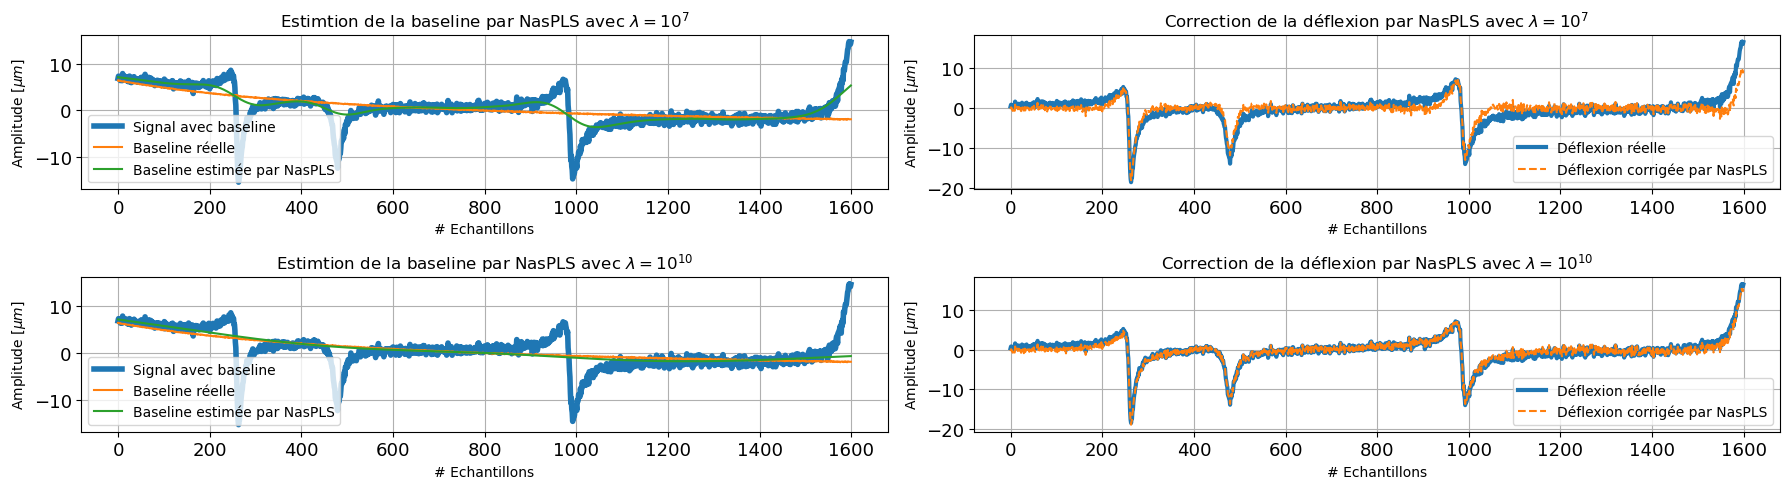

In [30]:
# Exemple de correction de la déflexion par NasPLS pour quelques valeurs de lambda
lambdas = 1e7
best_base, best_lambda,rmse_bas,corr_coeff = naspls(X_ct[i,:,0],[lambdas],niter=20,tol=1e-8,y_baseline=None,epsilon=0.99)

fig = plt.figure(figsize=(18,5))
plt.subplot(2,2,1)
plt.plot(X_ct[i,:,0],label='Signal avec baseline',linewidth=4)
plt.plot(Baseline[i,:],label='Baseline réelle')

plt.plot(best_base,label='Baseline estimée par NasPLS')
plt.xlabel('# Echantillons')
plt.ylabel(r'Amplitude [$\mu m$]')
plt.grid()
plt.legend()
plt.title(r'Estimtion de la baseline par NasPLS avec $\lambda = 10^{7}$')
plt.subplot(2,2,2)
plt.plot(Y_real[i,:,0],linewidth=3,label='Déflexion réelle')
plt.plot(X_ct[i,:,0]-best_base,'--',label='Déflexion corrigée par NasPLS')
plt.xlabel('# Echantillons')
plt.ylabel(r'Amplitude [$\mu m$]')
plt.grid()
plt.legend()
plt.title(r'Correction de la déflexion par NasPLS avec $\lambda = 10^{7}$')


lambdas = 1e10
best_base, best_lambda,rmse_bas,corr_coeff = naspls(X_ct[i,:,0],[lambdas],niter=20,tol=1e-8,y_baseline=None,epsilon=0.99)

plt.subplot(2,2,3)
plt.plot(X_ct[i,:,0],label='Signal avec baseline',linewidth=4)
plt.plot(Baseline[i,:],label='Baseline réelle')

plt.plot(best_base,label='Baseline estimée par NasPLS')
plt.xlabel('# Echantillons')
plt.ylabel(r'Amplitude [$\mu m$]')
plt.grid()
plt.legend()
plt.title(r'Estimtion de la baseline par NasPLS avec $\lambda = 10^{10}$')
plt.subplot(2,2,4)
plt.plot(Y_real[i,:,0],linewidth=3,label='Déflexion réelle')
plt.plot(X_ct[i,:,0]-best_base,'--',label='Déflexion corrigée par NasPLS')
plt.xlabel('# Echantillons')
plt.ylabel(r'Amplitude [$\mu m$]')
plt.grid()
plt.legend()
plt.title(r'Correction de la déflexion par NasPLS avec $\lambda = 10^{10}$')

plt.tight_layout()
plt.show()

La figure ci-haut affiche l'estimation de la baseline par la méthode NasPLS pour des valeurs de $\lambda$ de $10^7$ et $10^{10}$. Il peut être observée que pour une valeur de $\lambda$ de $10^10$ l'écart entre l'estimation et la baseline réelle (courbe en haut à gauche) est faible. Pour la déflexion corrigée, c'est à dire la courbe obtenue après soustraction de la ligne de base estimée, cet écart est également faible. 

In [31]:
# Estimation baseline par NasPLS
l_range = np.array(np.logspace(0,13,14))

Na = 20
ss = np.zeros((Na*8,len(l_range)))
mse = np.zeros((Na*8,len(l_range)))
mae = np.zeros((Na*8,len(l_range)))
for i in range(Na*8):
    it = 0
    for lambdas in l_range:
        best_base, best_lambda,rmse_bas,corr_coeff = naspls(X_ct[i,:,0],[lambdas],niter=20,tol=1e-8,y_baseline=None,epsilon=0.99)
        ss[i,it] = ssim(Y_real[i,:,0],X_ct[i,:,0]-best_base)
        mse[i,it] = nmse(Y_real[i,:,0],X_ct[i,:,0]-best_base)
        mae[i,it] = mean_absolute_error(best_base,Baseline[i,:,0])
        it=it+1



C:\Users\s602073\AppData\Local\Temp\ipykernel_31916\1744457190.py:46: RuntimeWarning: overflow encountered in exp
  w_new = 1 / (1 + np.exp(4*(d - (-1*m+2*s)) / s))
C:\Users\s602073\AppData\Local\Temp\ipykernel_31916\1744457190.py:46: RuntimeWarning: overflow encountered in exp
  w_new = 1 / (1 + np.exp(4*(d - (-1*m+2*s)) / s))
C:\Users\s602073\AppData\Local\Temp\ipykernel_31916\1744457190.py:46: RuntimeWarning: overflow encountered in exp
  w_new = 1 / (1 + np.exp(4*(d - (-1*m+2*s)) / s))
C:\Users\s602073\AppData\Local\Temp\ipykernel_31916\1744457190.py:46: RuntimeWarning: overflow encountered in exp
  w_new = 1 / (1 + np.exp(4*(d - (-1*m+2*s)) / s))
C:\Users\s602073\AppData\Local\Temp\ipykernel_31916\1744457190.py:46: RuntimeWarning: overflow encountered in exp
  w_new = 1 / (1 + np.exp(4*(d - (-1*m+2*s)) / s))
C:\Users\s602073\AppData\Local\Temp\ipykernel_31916\1744457190.py:46: RuntimeWarning: overflow encountered in exp
  w_new = 1 / (1 + np.exp(4*(d - (-1*m+2*s)) / s))
C:\Users\s

### Affichage Métriques du NasPLS en fonction des valeurs de $\lambda$

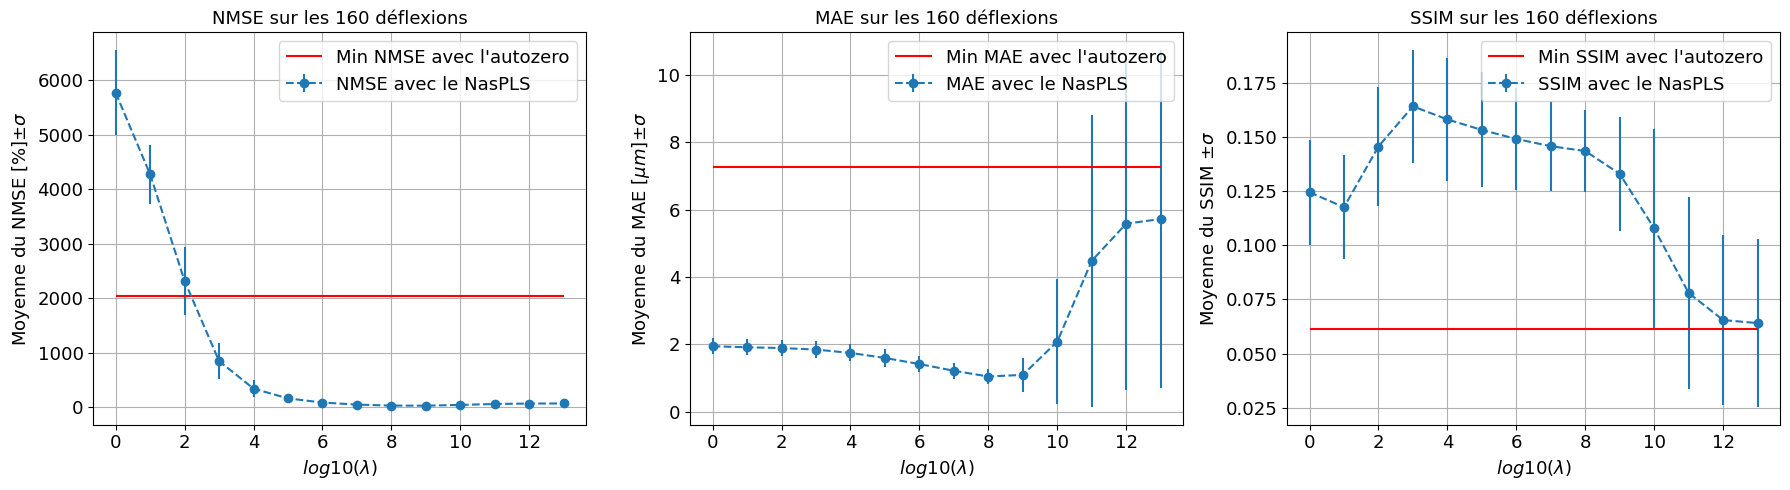

In [32]:
# Métriques avec le NasPLS
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.errorbar(x=np.log10(l_range), y=np.mean(mse,axis=0),yerr=np.std(mse,axis=0),fmt='--o',label='NMSE avec le NasPLS')

plt.hlines(min(error_mean[0,:]),np.log10(l_range[0]),np.log10(l_range[-1]),'r',label="Min NMSE avec l'autozero")
plt.xlabel(r'$log10(\lambda)$',fontsize=13)
plt.ylabel(r'Moyenne du NMSE [%]$\pm \sigma$',fontsize=13)
# plt.ylim(0,50)
plt.legend(fontsize=13)
plt.grid()
plt.title('NMSE sur les 160 déflexions',fontsize=13)

plt.subplot(1,3,2)
plt.errorbar(x=np.log10(l_range), y=np.mean(mae,axis=0),yerr=np.std(mae,axis=0),fmt='--o',label='MAE avec le NasPLS')
plt.hlines(min(mae_mean[0,:]),np.log10(l_range[0]),np.log10(l_range[-1]),'r',label="Min MAE avec l'autozero")
plt.xlabel(r'$log10(\lambda)$',fontsize=13)
plt.ylabel(r'Moyenne du MAE [$\mu m$]$\pm \sigma$',fontsize=13)
plt.legend(fontsize=13)
# plt.ylim(0,4)
plt.grid()
plt.title('MAE sur les 160 déflexions',fontsize=13)

plt.subplot(1,3,3)
plt.errorbar(x=np.log10(l_range), y=np.mean(ss,axis=0),yerr=np.std(ss,axis=0),fmt='--o',label='SSIM avec le NasPLS')
plt.hlines(min(ssim_mean[0,:]),np.log10(l_range[0]),np.log10(l_range[-1]),'r',label="Min SSIM avec l'autozero")
plt.xlabel(r'$log10(\lambda)$',fontsize=13)
plt.ylabel(r'Moyenne du SSIM $\pm \sigma$',fontsize=13)
# plt.ylim(-.04,.04)
plt.legend(fontsize=13)
plt.grid()
plt.title('SSIM sur les 160 déflexions',fontsize=13)
plt.tight_layout()
plt.show()

La figure ci-haut affiche les métriques entre la déflexion réelle et la déflexion corrigée par NasPLS. Nous affichons la moyenne des métriques sur 160 déflexions avec l'ecart-type associé. 
Nous constations qu'il existe une valeur optimale de $\lambda$ fournissant le minimum d'errreur. En plus de cela, les erreurs obtenues avec le NasPLS sont inférieures en moyenne à celle de la méthode classique; et ce, peu importe la valeur de $\lambda$.

Le SSIM du NasPLS est également superieure à celui de l'autozero. Ce qui confirme encore la supériorité du NasPLS sur cet exemple. 

Cependant, l'inconvénient du NasPLS repose sur le manque de métrique permettant de choisir la valeur optimale de $\lambda$. 

# $\color{blue}{\text{7. Approche basée données : Deep Learning - U-NET}}$

Dans l'approche basée données, nous avons exploré un modèle de Deep Learning : l'architecture U-NET. Cette architecture a été initialement appliquée pour la segmentation d'image et a fournit des résultats satisfaisants. Dans la problématique de suppression de ligne de base, elle a égaleemnt été appliquée en spectroscopie ([Ref_article](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/full/10.1002/jrs.6053)). 
Nous nous sommes inspirés de ces travaux pour faire la correction de baseline sur les déflexions d'aubes.

In [5]:
# importation de libraities tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## $\color{blue}{\text{7.1 Construction des fonctions de convolution pour le U-Net}}$

In [6]:
# Double convolution avec Batch Normalisation
def double_conv_block(x, n_filters):
     # --- Encodeur ---
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

In [7]:
# Downsampling by Maxpoolin and dropout
def downsample_block(x, n_filters):
   x = double_conv_block(x, n_filters)
   p = layers.MaxPooling1D(2)(x)
   p = layers.Dropout(0.2)(p)
   return x, p

In [8]:
# Upsampling block
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv1DTranspose(n_filters, kernel_size=2, strides=2)(x)  
   # x = layers.UpSampling1D(2)(x)
 
   # concatenate
   x = layers.Concatenate()([x, conv_features])
   # dropout
   #x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [9]:
# Fonction principale du Unet
def build_unet1dres_model(input_shape):
    """Construit le modèle Unet1DRes pour le débruitage (Module 2)."""
    inputs = keras.Input(shape=input_shape)

    # --- Encodeur ---
    c0, p0  = downsample_block(inputs, n_filters=32)

    c1, p1  = downsample_block(p0, n_filters=64)

    c2 , p2 = downsample_block(p1, n_filters=128)

    c3, p3 = downsample_block(p2, n_filters=256)

    c4,p4 = downsample_block(p3, n_filters=512)

    # --- Bottleneck ---
    bn = double_conv_block(p4, n_filters=1024)

    # --- Décodeur ---
    uc4 = upsample_block(bn, c4, n_filters=512)

    uc3 = upsample_block(uc4, c3, n_filters=256)
    
    uc2 = upsample_block(uc3, c2, n_filters=128)

    uc1 = upsample_block(uc2, c1, n_filters=64)

    uc0 = upsample_block(uc1, c0, n_filters=32)
    # Le modèle prédit le signal corrigé
    output = layers.Conv1D(1, 1,padding='same', activation='linear')(uc0)

    # Connexion résiduelle : Signal d'entrée - Bruit prédit = Signal débruité
    # denoised_signal = layers.Subtract(name="residual_connection")([inputs, predicted_noise])
    
    model = keras.Model(inputs, output, name="Unet1D")
    # Pour entraîner, nous compilons pour prédire le bruit, mais le modèle renvoie le signal propre.
    # Pour simplifier ici, nous entraînons le modèle à prédire directement le signal propre.
    # L'entraînement pour prédire le bruit peut être fait en définissant le modèle avec `predicted_noise`
    # comme sortie et en utilisant `y_target = X_input - y_clean`.
    
    return model

## $\color{blue}{\text{7.2 Génération de la base de donnée pour l'entrainement du U-Net}}$

Pour entrainer le modèle Unet, 120 000 exemples de signaux de 1600 points ont été genérés. La validation est fait sur 20% de la donnée. 
L'entrainement a été fait sur une carte graphique NVIDIA GeForce RTX 3060 Ti de 8 Go.  

Ne pas lancer la fonction de génération de données. Elle prendra une vingtaine de minutes.

In [ ]:
# --- Génération du dataset ---
X_ct, Y_real, Baseline,DCt_raw, Fr,Def_struct = generate_ct_dataset(
max_samples=100000,      # nombre de signaux. Une configuration de machine fait 8*Na exemples
sigma_min=0, sigma_max=30*1e-9,  # plage de bruit
Na=96,                  # nombre d'aubes   # Engine Orders multiples
)

In [ ]:
# Chargement de la donnée générée
data = np.load('data_simu_complet.npy',allow_pickle=True)

X_ct = data.item().get('X')
Y_real = data.item().get('Y')
Baseline = data.item().get('baseline')

In [ ]:
# Split de la donnée
TEST_SPLIT = 0.1

X = X_ct.squeeze()
Y = Y_real.squeeze()
Baseline = Baseline.squeeze()
# --- Split train/test ---
split = int(len(X) * (1 - TEST_SPLIT))
X_train, X_test = X[:split,:], X[split:,:]
Y_train, Y_test = Y[:split,:], Y[split:,:]
Baseline_train, Baseline_test = Baseline[:split,:], Baseline[split:,:]


In [ ]:
# Forcer la longueur des signaux à un multiple de 16 (pour 4 niveaux de MaxPooling)
def adjust_length(arr, multiple=16):
    target_len = (arr.shape[1] // multiple) * multiple
    return arr[:, :target_len]


X_train = adjust_length(X_train)
X_test = adjust_length(X_test)
Y_train = adjust_length(Y_train)
Y_test = adjust_length(Y_test)

Baseline_train = adjust_length(Baseline_train)
Baseline_test = adjust_length(Baseline_test)

from sklearn.preprocessing import StandardScaler
normalizer_X = StandardScaler()
X_train = normalizer_X.fit_transform(X_train)
X_test = normalizer_X.transform(X_test)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


Y_train = Y_train[..., np.newaxis]
Y_test = Y_test[..., np.newaxis]

Baseline_train = Baseline_train[..., np.newaxis]
Baseline_test = Baseline_test[..., np.newaxis]

SIGNAL_LENGTH = np.shape(X_train)[1]

In [10]:
SIGNAL_LENGTH = 1600

In [11]:
# Compilation du modèle
print("\n--- Compilation du modèle avec callbacks ---")
# Callback pour sauvegarder le modèle
checkpoint = ModelCheckpoint('best_model.keras', 
                                save_best_only=True, 
                                monitor='val_loss',
                                mode='min')

# callback pour arreter l'apprentissage
early_stopping = EarlyStopping(monitor = 'val_loss',
                           min_delta = 1e-3,
                           patience = 5,
                           verbose = 1,
                           mode = 'min')

# Callback pour réduire le taux d'apprentissage
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1, 
    patience=3,  
    min_lr=1e-7,
)

# model = build_model((SIGNAL_LENGTH, )) # NNFit utilise des entrées plates
model = build_unet1dres_model((SIGNAL_LENGTH, 1))

model.compile(optimizer=keras.optimizers.AdamW(learning_rate=5*1e-4), loss='mse',metrics=['mean_absolute_error'])

model.summary()


--- Compilation du modèle avec callbacks ---


Model: "Unet1D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1600, 32)  │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1600, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1600, 32)  │      3,104 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 32)  │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 800, 32)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 800, 64)   │      6,208 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 800, 64)   │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 400, 64)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 400, 128)  │     24,704 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 128)  │        512 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 400, 128)  │     49,280 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 128)  │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 200, 128)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 200, 128)  │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 200, 256)  │     98,560 │ dropout_2[0][0] 

 Total params: 10,858,977 (41.42 MB)

 Trainable params: 10,846,945 (41.38 MB)

 Non-trainable params: 12,032 (47.00 KB)

In [20]:
import visualkeras
# visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 64)

visualkeras.layered_view(model, legend=True, font=font, draw_volume=False,spacing=30,to_file='output.png').show()


In [ ]:
#  Entraînement du modèle
print("\n--- Entraînement du modèle (Baseline Correction) ---")
# Note: NNFit attend une entrée de forme (batch, features)
EPOCHS = 30
BATCH_SIZE = 100
model_history = model.fit(
    np.squeeze(X_train, axis=-1), 
    np.squeeze(Y_train, axis=-1),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[early_stopping,reduceLR,checkpoint]
)

#### Chargement du modèle UNET entrainé

In [172]:
from tensorflow.keras.layers import Conv1DTranspose
 
class PatchedConv1DTranspose(Conv1DTranspose):
    def __init__(self, **kwargs):
        kwargs.pop("groups", None)  # on supprime le paramètre non reconnu
        super().__init__(**kwargs)
 
from tensorflow.keras.models import load_model
model_unet = load_model(
    "best_model.h5",
    custom_objects={"Conv1DTranspose": PatchedConv1DTranspose}
)

c:\Users\s602073\AppData\Local\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Performance du modèle en fonction des epochs

train_acc = model_history.history['loss']
val_acc = model_history.history['val_loss']
plt.figure(figsize=(15,5))
plt.plot(train_acc,'o-',label='MSE en training')
plt.plot((val_acc),'s-',label='MSE en validation')
plt.title('Evolution de la performance du UNET')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('# Epochs')
plt.grid('on')

plt.show()

## $\color{blue}{\text{7.3 Correction de quelques exemples par le modèle entrainé}}$

In [178]:
# --- Génération du dataset ---
X_ct, Y_real, Baseline,DCt_raw, Fr,Def_struct = generate_ct_dataset(
max_samples=160,      # nombre de signaux. Une configuration de machine fait 8*Na exemples
sigma_min=0, sigma_max=5*1e-9,  # plage de bruit
Na=20,                  # nombre d'aubes
reg_acc=80,
reg_init=3000,
reg_end=6000,
)

Génération de 160 signaux Center-Time multi-pics...


Signaux générés:   0%|          | 0/160 [00:01<?, ?it/s]


In [179]:
# Normalisation de la donnée par le scaler
import pickle
scaler = pickle.load(open('scaler.pkl','rb')) 
X_scaled = scaler.transform(X_ct[:,:,0])
# Prédiction du signal corrigé par le modèle entrainé
Y_pred = model_unet.predict(np.squeeze(X_scaled[...,np.newaxis], axis=-1))

c:\Users\s602073\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


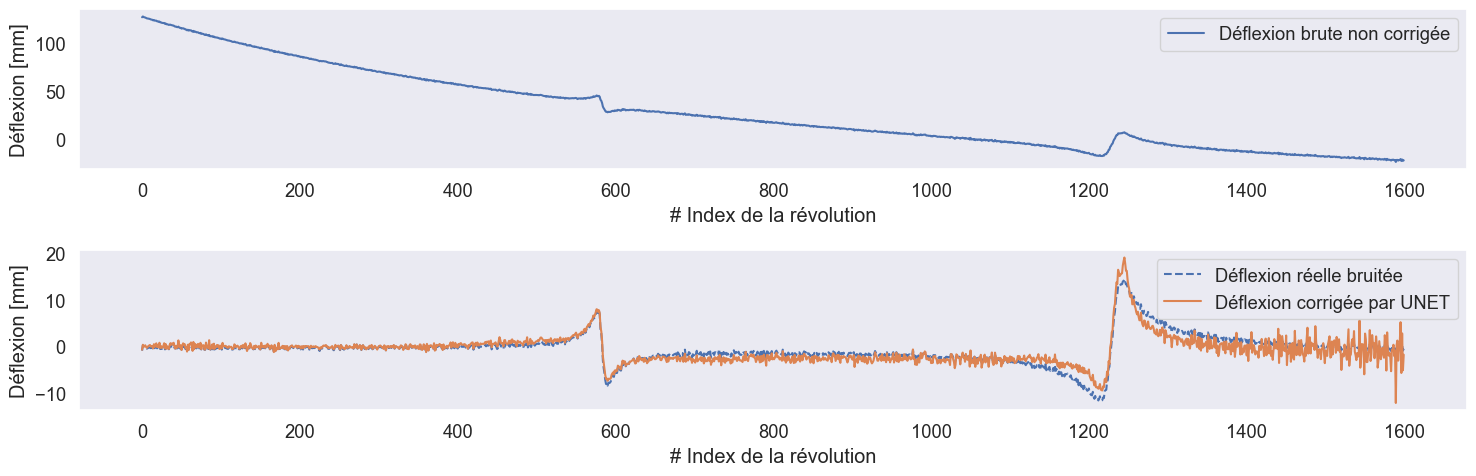

In [187]:
i = np.random.randint(0,np.shape(X_ct)[0])
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(X_ct[i,:,0],label='Déflexion brute non corrigée')
plt.ylabel('Déflexion [mm]')
plt.xlabel('# Index de la révolution')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.plot(Y_real[i,:,0],'--',label='Déflexion réelle bruitée')
plt.plot(Y_pred[i,:,0],label='Déflexion corrigée par UNET')

plt.xlabel('# Index de la révolution')
plt.grid()
plt.legend()
plt.ylabel('Déflexion [mm]')
plt.tight_layout()
plt.show()

# $\color{blue}{\text{8. Comparaison des différentes méthodes de correction de la baseline}}$

## 8.1 Application des méthodes sur les données simulées

### Génération de la donnée de test

In [19]:
# --- Génération du dataset ---
X_ct, Y_real, Baseline,DCt_raw, Fr,Def_struct = generate_ct_dataset(
max_samples=160,      # nombre de signaux. Une configuration de machine fait 8*Na exemples
sigma_min=0, sigma_max=10*1e-9,  # plage de bruit
Na=20,                  # nombre d'aubes
reg_acc=100,
reg_init=3000,
reg_end=6000,
)

Génération de 160 signaux Center-Time multi-pics...


Signaux générés:   0%|          | 0/160 [00:01<?, ?it/s]


In [23]:
x = np.zeros((160,))
df_error = pd.DataFrame({'nmse_autozero': x,
                         'nmse_pls': x,
                         'nmse_unet': x,
                         'mae_autozero': x,
                         'mae_pls': x,
                         'mae_unet': x,                         
                         'ssim_autozero': x,
                         'ssim_pls': x,
                         'ssim_unet': x,})

df_error.head()

,nmse_autozero,nmse_pls,nmse_unet,mae_autozero,mae_pls,mae_unet,ssim_autozero,ssim_pls,ssim_unet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Application auto-zero et calcul des métriques

In [24]:
from auto_zero import *
ordre = 1
S = 0.2 #,0.3,0.4]
    
Dzero = autozero(DCt_raw[0,:,:,:], Fr[0,:,0], ordre, S, 5)
tmp1 = []
tmp2 = []
tmp3 = []
for aub in range(np.shape(Dzero)[0]):
    for capt in range(np.shape(Dzero)[2]):

        tmp1.append(nmse(Dzero[aub,:1600,capt],Y_real[8*aub+capt,:,0]))
        tmp2.append(ssim(Dzero[aub,:1600,capt],Y_real[8*aub+capt,:,0]))
        tmp3.append(mean_absolute_error(Dzero[aub,:1600,capt],Y_real[8*aub+capt,:,0]))

df_error['nmse_autozero'] = np.array(tmp1)
df_error['ssim_autozero'] = np.array(tmp2)
df_error['mae_autozero'] = np.array(tmp3)


### Application PLS et calcul des métriques 

In [27]:
# Estimation baseline par NasPLS
l_range = np.array(np.logspace(10,10,1))
tmp1 = []
tmp2 = []
tmp3 = []
for i in range(np.shape(X_ct)[0]):
    for lambdas in l_range:
        best_base, best_lambda,rmse_bas,corr_coeff = naspls(X_ct[i,:,0],[lambdas],niter=20,tol=1e-8,y_baseline=None,epsilon=0.99)
        tmp1.append(nmse(Y_real[i,:,0],X_ct[i,:,0]-best_base))
        tmp2.append(ssim(Y_real[i,:,0],X_ct[i,:,0]-best_base))
        tmp3.append(mean_absolute_error(Y_real[i,:,0],X_ct[i,:,0]-best_base))

df_error['nmse_pls'] = np.array(tmp1)
df_error['ssim_pls'] = np.array(tmp2)
df_error['mae_pls'] = np.array(tmp3)

C:\Users\s602073\AppData\Local\Temp\ipykernel_4516\1744457190.py:46: RuntimeWarning: overflow encountered in exp
  w_new = 1 / (1 + np.exp(4*(d - (-1*m+2*s)) / s))


### Prédiction UNET et calcul des métriques 

In [169]:
# Chargement du modèle UNET entriané
from tensorflow.keras.layers import Conv1DTranspose
 
class PatchedConv1DTranspose(Conv1DTranspose):
    def __init__(self, **kwargs):
        kwargs.pop("groups", None)  # on supprime le paramètre non reconnu
        super().__init__(**kwargs)
 
from tensorflow.keras.models import load_model
model_unet = load_model("best_model.h5",custom_objects={"Conv1DTranspose": PatchedConv1DTranspose})

c:\Users\s602073\AppData\Local\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [170]:
# Correction par UNET
# Normalisation de la donnée par le scaler
import pickle
scaler = pickle.load(open('scaler.pkl','rb')) 
X_scaled = scaler.transform(X_ct[:,:,0])
# Prédiction du signal sans baseline par le modèle entrainé

Y_pred = model_unet.predict(np.squeeze(X_scaled[...,np.newaxis], axis=-1))



for i in range(160):
    df_error.loc[i,'ssim_unet'] = ssim(Y_real[i,:,0],Y_pred[i,:,0])
    df_error.loc[i,'nmse_unet'] = nmse(Y_real[i,:,0],Y_pred[i,:,0])
    df_error.loc[i,'mae_unet'] = mean_absolute_error(Y_real[i,:,0],Y_pred[i,:,0])


c:\Users\s602073\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


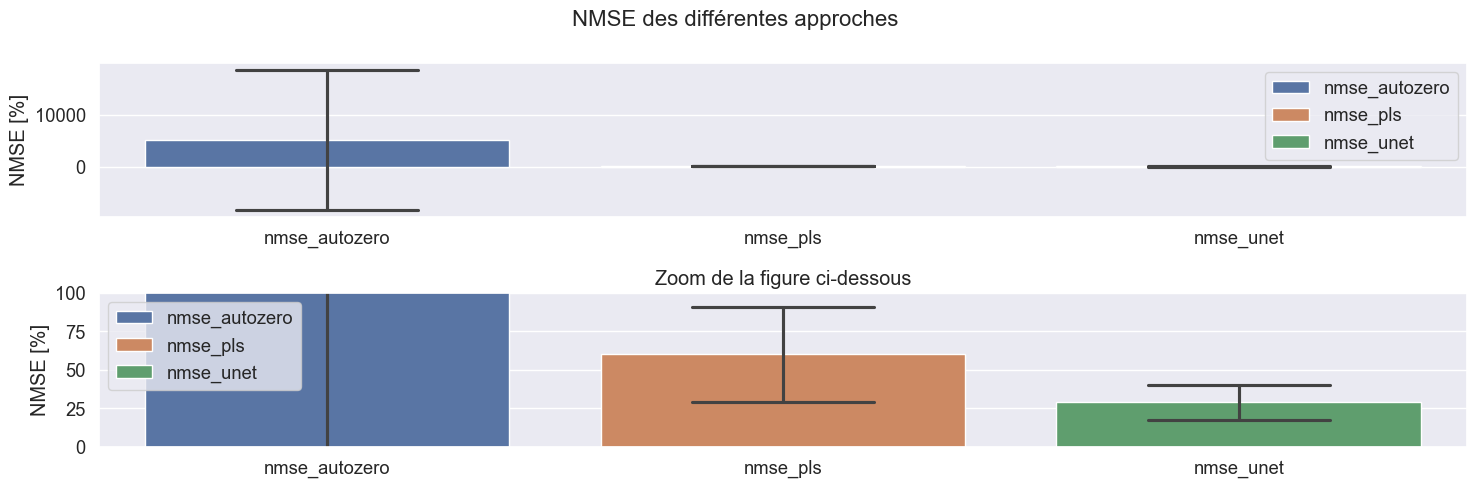

In [171]:
# Affichage des métriques par approche
import seaborn as sns
sns.set(font_scale=1.2)
plt.figure(figsize=(15,5))

plt.subplot(2,1,1)
ax = sns.barplot(df_error[['nmse_autozero','nmse_pls','nmse_unet']], errorbar="sd", legend=True,capsize=.4)

plt.ylabel('NMSE [%]')

plt.subplot(2,1,2)
sns.barplot(df_error[['nmse_autozero','nmse_pls','nmse_unet']], errorbar="sd", legend=True,capsize=.4)
plt.ylim(0,100)
plt.ylabel('NMSE [%]')

plt.title('Zoom de la figure ci-dessous')

st = plt.suptitle("NMSE des différentes approches ", fontsize=16)

plt.tight_layout()
plt.show()

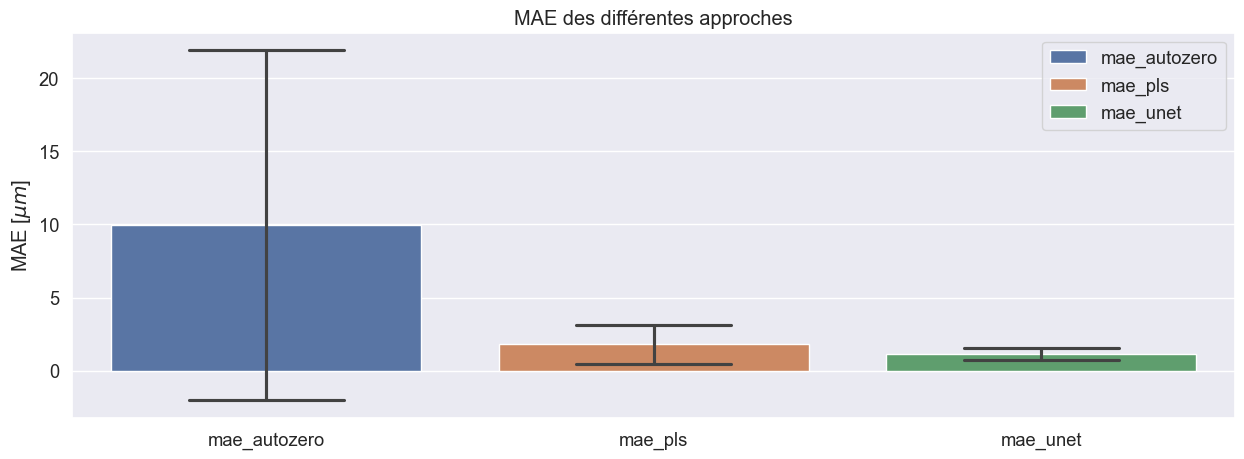

In [167]:
plt.figure(figsize=(15,5))
sns.barplot(df_error[['mae_autozero','mae_pls','mae_unet']], errorbar="sd", legend=True,capsize=.4)
plt.ylabel(r'MAE [$\mu m$]')
plt.title('MAE des différentes approches')
plt.show()

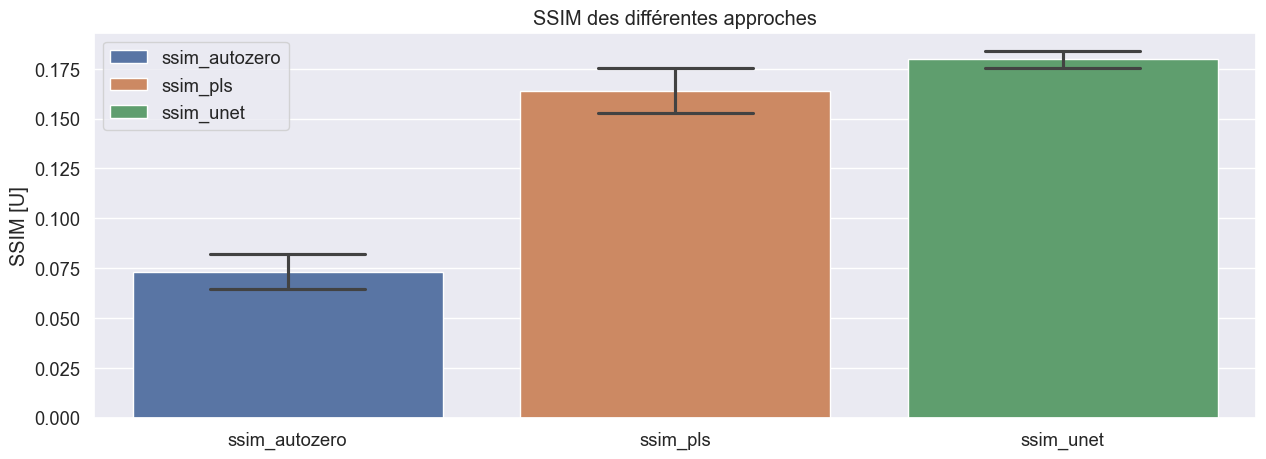

In [168]:
plt.figure(figsize=(15,5))
sns.barplot(df_error[['ssim_autozero','ssim_pls','ssim_unet']],legend=True,capsize=.4)
plt.ylabel(r'SSIM [U]')
plt.title('SSIM des différentes approches')
plt.show()

### Commentaires sur les métriques des différentes approches

Les métriques montrent que le modèle de UNET performe le mieux par rapport aux autres méthodes de correction de la ligne de base; et ce peu importe la métrique. La méthode traditionnelle est la moins performante. Ses métriques présentent le plus grand écart-type. 
il est à noter également que la méthode de la PLS présente des performances similaires au UNET. Elle a l'avantage de ne pas necessiter de données pour sa mise en oeuvre. 

# Conlusions et perspectives

Nous avons présenté dans cette notebook la problématique liée à l'estimation de la déflexion des aubes à partir des temps de passage d ces dernières devant les capteurs tip-timing. La méthode traditionnelle utilisée est le center-time mise en place au sein de Safran Aircraft Engines. 
Le center-time necessite une étape de correction de la déflexion estimée appéllée zeroing. Cette étape est une des plus critiques dans l'analyse des données tip-timing. En effet, nous avons mis en evidence que le zeroing réquiert le choix de deux patramètres ; et ce choix est aujourd'hui subjectif et peut conduire à des erreurs d'estimation différentes d'un utilisateur à l'autre.

La problématique d'estimation de la déflexion ouvre plusieurs perspectives d'un point de vue de l'apprentissage automatique. Celles rétenues dans ce travail sont les suivantes :

1. Une première est de construire un modèle d'apprentissage automatique qui prédit la déflexion à partir des temps de passage, du régime, du temps de référence et d'autres grandeurs physiques pertinentes.
2. Une deuxième est de construire un modèle d'apprentissage qui prédit la fonction zéro à partir de la déflexion brute estimée par le center-time

Ces deux perspectives seront explorées dans cette étude et détaillées dans une nouvelle notebook.